# Data sources

## Read pre-trained dictionary file

In [2]:
import csv
import numpy as np
import emoji
import pandas as pd

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

## Read input data file (format csv, colume 1: sentence, colume 2: label)

In [4]:
def read_csv(filename):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

## One-hot encoding label

In [5]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

## Encode sentence to indices of word

In [6]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`

    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this.

    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """

    m = X.shape[0]  # number of training examples
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))

    for i in range(m):  # loop over training examples
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = (X[i].lower()).split()
        # Initialize j to 0
        j = 0
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j = j + 1
    return X_indices

## Preprocess data, encode input data and labels

In [9]:
def preprocess_data(X, Y, C, word_to_index, max_len):
    # Convert each sentence to array of index in dictionary
    X_indices = sentences_to_indices(X, word_to_index, max_len)

    # Converts label to OneHot vector with len = C
    Y_oh = convert_to_one_hot(Y, C=C)
    return X_indices, Y_oh


def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    emoji_dictionary = {"1": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                        "0": ":disappointed:"}
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)
              

## Embedding layer

In [11]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import numpy as np
from keras.layers.embeddings import Embedding

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.

    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]  # define dimensionality of your GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False.
    embedding_layer = Embedding(vocab_len, emb_dim)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

## Model

In [13]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, LeakyReLU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, Callback
import datetime


def SentimentAnalysis(input_shape, classes_nb, embedding_layer):
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype=np.int32)

    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)

    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # X = Dense(256)(X)
    # X = LeakyReLU(alpha=0.15)(X)
    # X = Dropout(0.5)(X)
    # X = Dense(128)(X)
    X = LeakyReLU(alpha=0.15)(X)
    
    X = Dense(classes_nb)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)

    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)

    # Show summary of model
    model.summary()

    # Compiple model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model


class TrainingHistory(Callback):
  def __init__(self, net):
    self.net = net
  
  def on_train_begin(self, logs={}):
    self.histories = []

  def on_epoch_end(self, epoch, logs={}):
    self.histories.append([logs.get('loss'), logs.get('accuracy'), 
                           logs.get('val_loss'), logs.get('val_accuracy')])
    np.savetxt("./model/"+self.net+"-history.txt", self.histories, delimiter=",")


def today():
  return '{:02d}{:02d}'.format(datetime.date.today().month, datetime.date.today().day)

def callbacks(net_name):
    # checkpoint
    filepath="./model/"+net_name+"-"+ today() +"-weights-{epoch:02d}-{loss:.2f}-{accuracy:.2f}-{val_loss:.2f}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    log_history = TrainingHistory(net_name)
    callbacks = [checkpoint, log_history]
    return callbacks


In [14]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import sys
import numpy as np
from sklearn.model_selection import train_test_split
from data_sources import *    
from visualization import *
from embedding import *
from model import *
np.random.seed(1)

## Load dictionary and input data

In [15]:
# Read train and test files
print("Loading raw data")
X, Y = read_csv('imdb_labelled.txt.csv')

# Read 50 feature dimension glove file
print("Loading dictionary file.")
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

Loading raw data
Loading dictionary file.


## preprocess data and split train/test set

In [17]:
CLASSES_NUMBER = 2
NET_NAME = 'sentiment'
# Compute max length of sentences set
maxLen = len(max(X, key=len).split())

# Preprocess input data
X, Y = preprocess_data(X, Y, CLASSES_NUMBER, word_to_index, maxLen)

# Split train/test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Build model

In [18]:
# Create the embedding layer pretrained with GloVe Vectors (≈1 line)
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
# Model and model summmary
model = SentimentAnalysis((maxLen,), CLASSES_NUMBER, embedding_layer)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 74)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 74, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 74, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0   

## Train model

In [25]:
epochs = 2000

net_name = NET_NAME + str(epochs)
model.fit(X_train, Y_train, 
          epochs=epochs, 
          batch_size=64, 
          workers=4,
          shuffle=True, 
          validation_data=(X_test, Y_test), 
          callbacks=callbacks(net_name))

# Visualize History of Traing model
show_training_history("./model/"+NET_NAME + str(epochs)+"-history.txt")
# Evaluate model, loss and accuracy
loss, acc = model.evaluate(X_test, Y_test, verbose=1)
print()
print("Test accuracy = ", acc)

Train on 800 samples, validate on 200 samples
Epoch 1/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6927 - accuracy: 0.5125 - val_loss: 0.6933 - val_accuracy: 0.4700

Epoch 00001: val_accuracy improved from -inf to 0.47000, saving model to ./model/sentiment2000-1124-weights-01-0.69-0.51-0.69-0.47.hdf5
Epoch 2/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6630 - accuracy: 0.6313 - val_loss: 0.9461 - val_accuracy: 0.6100

Epoch 00002: val_accuracy improved from 0.47000 to 0.61000, saving model to ./model/sentiment2000-1124-weights-02-0.66-0.63-0.95-0.61.hdf5
Epoch 3/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6917 - accuracy: 0.6212 - val_loss: 0.6532 - val_accuracy: 0.6200

Epoch 00003: val_accuracy improved from 0.61000 to 0.62000, saving model to ./model/sentiment2000-1124-weights-03-0.69-0.62-0.65-0.62.hdf5
Epoch 4/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6296 - accuracy: 0.6363 - 

800/800 [==============================] - 7s 9ms/step - loss: 0.0412 - accuracy: 0.9925 - val_loss: 0.8222 - val_accuracy: 0.8000

Epoch 00036: val_accuracy did not improve from 0.83000
Epoch 37/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.0444 - accuracy: 0.9912 - val_loss: 0.8267 - val_accuracy: 0.8100

Epoch 00037: val_accuracy did not improve from 0.83000
Epoch 38/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.0417 - accuracy: 0.9912 - val_loss: 0.8078 - val_accuracy: 0.8000

Epoch 00038: val_accuracy did not improve from 0.83000
Epoch 39/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.0589 - accuracy: 0.9837 - val_loss: 0.8015 - val_accuracy: 0.8150

Epoch 00039: val_accuracy did not improve from 0.83000
Epoch 40/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.0445 - accuracy: 0.9912 - val_loss: 1.0483 - val_accuracy: 0.7850

Epoch 00040: val_accuracy did not improve from 0.83000
Epoch 41/

800/800 [==============================] - 8s 10ms/step - loss: 0.1036 - accuracy: 0.9787 - val_loss: 0.9556 - val_accuracy: 0.7550

Epoch 00077: val_accuracy did not improve from 0.83000
Epoch 78/2000
800/800 [==============================] - 9s 11ms/step - loss: 0.1085 - accuracy: 0.9800 - val_loss: 0.9532 - val_accuracy: 0.7550

Epoch 00078: val_accuracy did not improve from 0.83000
Epoch 79/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.1004 - accuracy: 0.9800 - val_loss: 0.9583 - val_accuracy: 0.7550

Epoch 00079: val_accuracy did not improve from 0.83000
Epoch 80/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.0967 - accuracy: 0.9812 - val_loss: 0.9522 - val_accuracy: 0.7600

Epoch 00080: val_accuracy did not improve from 0.83000
Epoch 81/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.0896 - accuracy: 0.9812 - val_loss: 0.9494 - val_accuracy: 0.7600

Epoch 00081: val_accuracy did not improve from 0.83000
Epoch 


Epoch 00117: val_accuracy did not improve from 0.83000
Epoch 118/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.0924 - accuracy: 0.9812 - val_loss: 0.9664 - val_accuracy: 0.7600

Epoch 00118: val_accuracy did not improve from 0.83000
Epoch 119/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.0950 - accuracy: 0.9812 - val_loss: 0.9669 - val_accuracy: 0.7600

Epoch 00119: val_accuracy did not improve from 0.83000
Epoch 120/2000
800/800 [==============================] - 8s 9ms/step - loss: 0.0919 - accuracy: 0.9812 - val_loss: 0.9564 - val_accuracy: 0.7600

Epoch 00120: val_accuracy did not improve from 0.83000
Epoch 121/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.0886 - accuracy: 0.9812 - val_loss: 0.9671 - val_accuracy: 0.7600

Epoch 00121: val_accuracy did not improve from 0.83000
Epoch 122/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.0949 - accuracy: 0.9812 - val_loss: 0.9757 - val_accura

800/800 [==============================] - 7s 9ms/step - loss: 0.0634 - accuracy: 0.9887 - val_loss: 1.0517 - val_accuracy: 0.7700

Epoch 00158: val_accuracy did not improve from 0.83000
Epoch 159/2000
800/800 [==============================] - 9s 11ms/step - loss: 0.0669 - accuracy: 0.9887 - val_loss: 1.0811 - val_accuracy: 0.7700

Epoch 00159: val_accuracy did not improve from 0.83000
Epoch 160/2000
800/800 [==============================] - 8s 9ms/step - loss: 0.0637 - accuracy: 0.9887 - val_loss: 1.0835 - val_accuracy: 0.7700

Epoch 00160: val_accuracy did not improve from 0.83000
Epoch 161/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.0660 - accuracy: 0.9887 - val_loss: 1.0852 - val_accuracy: 0.7700

Epoch 00161: val_accuracy did not improve from 0.83000
Epoch 162/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.0681 - accuracy: 0.9887 - val_loss: 1.0611 - val_accuracy: 0.7700

Epoch 00162: val_accuracy did not improve from 0.83000
Ep


Epoch 00198: val_accuracy did not improve from 0.83000
Epoch 199/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.0620 - accuracy: 0.9900 - val_loss: 1.0781 - val_accuracy: 0.7700

Epoch 00199: val_accuracy did not improve from 0.83000
Epoch 200/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.0572 - accuracy: 0.9900 - val_loss: 1.0997 - val_accuracy: 0.7700

Epoch 00200: val_accuracy did not improve from 0.83000
Epoch 201/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.0559 - accuracy: 0.9900 - val_loss: 1.1261 - val_accuracy: 0.7700

Epoch 00201: val_accuracy did not improve from 0.83000
Epoch 202/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.0563 - accuracy: 0.9900 - val_loss: 1.1140 - val_accuracy: 0.7700

Epoch 00202: val_accuracy did not improve from 0.83000
Epoch 203/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.0581 - accuracy: 0.9900 - val_loss: 1.1138 - val_accurac

800/800 [==============================] - 10s 12ms/step - loss: 0.8436 - accuracy: 0.6100 - val_loss: 0.7391 - val_accuracy: 0.4550

Epoch 00239: val_accuracy did not improve from 0.83000
Epoch 240/2000
800/800 [==============================] - 9s 12ms/step - loss: 0.7011 - accuracy: 0.5113 - val_loss: 0.6740 - val_accuracy: 0.5700

Epoch 00240: val_accuracy did not improve from 0.83000
Epoch 241/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6864 - accuracy: 0.4988 - val_loss: 0.6761 - val_accuracy: 0.5700

Epoch 00241: val_accuracy did not improve from 0.83000
Epoch 242/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6889 - accuracy: 0.4888 - val_loss: 0.6767 - val_accuracy: 0.5700

Epoch 00242: val_accuracy did not improve from 0.83000
Epoch 243/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6865 - accuracy: 0.4888 - val_loss: 0.6792 - val_accuracy: 0.4550

Epoch 00243: val_accuracy did not improve from 0.83000
E


Epoch 00279: val_accuracy did not improve from 0.83000
Epoch 280/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6788 - accuracy: 0.5113 - val_loss: 0.6756 - val_accuracy: 0.5700

Epoch 00280: val_accuracy did not improve from 0.83000
Epoch 281/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6782 - accuracy: 0.5225 - val_loss: 0.6761 - val_accuracy: 0.5700

Epoch 00281: val_accuracy did not improve from 0.83000
Epoch 282/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6794 - accuracy: 0.5000 - val_loss: 0.6774 - val_accuracy: 0.4550

Epoch 00282: val_accuracy did not improve from 0.83000
Epoch 283/2000
800/800 [==============================] - 8s 9ms/step - loss: 0.6800 - accuracy: 0.4600 - val_loss: 0.6779 - val_accuracy: 0.4550

Epoch 00283: val_accuracy did not improve from 0.83000
Epoch 284/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6795 - accuracy: 0.4975 - val_loss: 0.6777 - val_accur

800/800 [==============================] - 8s 10ms/step - loss: 0.6789 - accuracy: 0.5150 - val_loss: 0.6739 - val_accuracy: 0.5700

Epoch 00320: val_accuracy did not improve from 0.83000
Epoch 321/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6808 - accuracy: 0.4913 - val_loss: 0.6755 - val_accuracy: 0.5700

Epoch 00321: val_accuracy did not improve from 0.83000
Epoch 322/2000
800/800 [==============================] - 8s 9ms/step - loss: 0.6791 - accuracy: 0.5150 - val_loss: 0.6763 - val_accuracy: 0.5700

Epoch 00322: val_accuracy did not improve from 0.83000
Epoch 323/2000
800/800 [==============================] - 8s 11ms/step - loss: 0.6790 - accuracy: 0.5113 - val_loss: 0.6762 - val_accuracy: 0.5700

Epoch 00323: val_accuracy did not improve from 0.83000
Epoch 324/2000
800/800 [==============================] - 9s 12ms/step - loss: 0.6810 - accuracy: 0.5100 - val_loss: 0.6767 - val_accuracy: 0.5700

Epoch 00324: val_accuracy did not improve from 0.83000
Ep

800/800 [==============================] - 13s 16ms/step - loss: 0.6800 - accuracy: 0.4888 - val_loss: 0.6759 - val_accuracy: 0.5700

Epoch 00360: val_accuracy did not improve from 0.83000
Epoch 361/2000
800/800 [==============================] - 10s 12ms/step - loss: 0.6800 - accuracy: 0.5000 - val_loss: 0.6765 - val_accuracy: 0.5700

Epoch 00361: val_accuracy did not improve from 0.83000
Epoch 362/2000
800/800 [==============================] - 9s 11ms/step - loss: 0.6794 - accuracy: 0.4988 - val_loss: 0.6767 - val_accuracy: 0.5700

Epoch 00362: val_accuracy did not improve from 0.83000
Epoch 363/2000
800/800 [==============================] - 9s 11ms/step - loss: 0.6783 - accuracy: 0.5063 - val_loss: 0.6766 - val_accuracy: 0.5700

Epoch 00363: val_accuracy did not improve from 0.83000
Epoch 364/2000
800/800 [==============================] - 9s 11ms/step - loss: 0.6792 - accuracy: 0.5213 - val_loss: 0.6760 - val_accuracy: 0.5700

Epoch 00364: val_accuracy did not improve from 0.8300


Epoch 00400: val_accuracy did not improve from 0.83000
Epoch 401/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6786 - accuracy: 0.5412 - val_loss: 0.6762 - val_accuracy: 0.5700

Epoch 00401: val_accuracy did not improve from 0.83000
Epoch 402/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6802 - accuracy: 0.5025 - val_loss: 0.6766 - val_accuracy: 0.5700

Epoch 00402: val_accuracy did not improve from 0.83000
Epoch 403/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6784 - accuracy: 0.5013 - val_loss: 0.6763 - val_accuracy: 0.5700

Epoch 00403: val_accuracy did not improve from 0.83000
Epoch 404/2000
800/800 [==============================] - 11s 13ms/step - loss: 0.6789 - accuracy: 0.4875 - val_loss: 0.6779 - val_accuracy: 0.4550

Epoch 00404: val_accuracy did not improve from 0.83000
Epoch 405/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6792 - accuracy: 0.5038 - val_loss: 0.6787 - val_accu

800/800 [==============================] - 8s 10ms/step - loss: 0.6795 - accuracy: 0.5000 - val_loss: 0.6770 - val_accuracy: 0.4550

Epoch 00441: val_accuracy did not improve from 0.83000
Epoch 442/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6791 - accuracy: 0.5038 - val_loss: 0.6769 - val_accuracy: 0.4550

Epoch 00442: val_accuracy did not improve from 0.83000
Epoch 443/2000
800/800 [==============================] - 8s 9ms/step - loss: 0.6802 - accuracy: 0.4863 - val_loss: 0.6770 - val_accuracy: 0.4550

Epoch 00443: val_accuracy did not improve from 0.83000
Epoch 444/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6770 - accuracy: 0.4825 - val_loss: 0.6766 - val_accuracy: 0.5700

Epoch 00444: val_accuracy did not improve from 0.83000
Epoch 445/2000
800/800 [==============================] - 9s 12ms/step - loss: 0.6790 - accuracy: 0.4850 - val_loss: 0.6758 - val_accuracy: 0.5700

Epoch 00445: val_accuracy did not improve from 0.83000
Epo

800/800 [==============================] - 8s 10ms/step - loss: 0.6782 - accuracy: 0.5063 - val_loss: 0.6777 - val_accuracy: 0.4550

Epoch 00481: val_accuracy did not improve from 0.83000
Epoch 482/2000
800/800 [==============================] - 9s 11ms/step - loss: 0.6791 - accuracy: 0.5150 - val_loss: 0.6765 - val_accuracy: 0.5700

Epoch 00482: val_accuracy did not improve from 0.83000
Epoch 483/2000
800/800 [==============================] - 10s 12ms/step - loss: 0.6787 - accuracy: 0.5050 - val_loss: 0.6764 - val_accuracy: 0.5700

Epoch 00483: val_accuracy did not improve from 0.83000
Epoch 484/2000
800/800 [==============================] - 9s 12ms/step - loss: 0.6795 - accuracy: 0.5113 - val_loss: 0.6776 - val_accuracy: 0.4550

Epoch 00484: val_accuracy did not improve from 0.83000
Epoch 485/2000
800/800 [==============================] - 9s 12ms/step - loss: 0.6789 - accuracy: 0.4950 - val_loss: 0.6768 - val_accuracy: 0.4550

Epoch 00485: val_accuracy did not improve from 0.83000

800/800 [==============================] - 7s 9ms/step - loss: 0.6797 - accuracy: 0.4963 - val_loss: 0.6772 - val_accuracy: 0.4550

Epoch 00521: val_accuracy did not improve from 0.83000
Epoch 522/2000
800/800 [==============================] - 8s 9ms/step - loss: 0.6795 - accuracy: 0.4825 - val_loss: 0.6763 - val_accuracy: 0.5700

Epoch 00522: val_accuracy did not improve from 0.83000
Epoch 523/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6787 - accuracy: 0.5225 - val_loss: 0.6773 - val_accuracy: 0.4550

Epoch 00523: val_accuracy did not improve from 0.83000
Epoch 524/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6786 - accuracy: 0.5263 - val_loss: 0.6784 - val_accuracy: 0.4550

Epoch 00524: val_accuracy did not improve from 0.83000
Epoch 525/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6784 - accuracy: 0.5238 - val_loss: 0.6782 - val_accuracy: 0.4550

Epoch 00525: val_accuracy did not improve from 0.83000
Epoc


Epoch 00561: val_accuracy did not improve from 0.83000
Epoch 562/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6785 - accuracy: 0.4863 - val_loss: 0.6762 - val_accuracy: 0.5700

Epoch 00562: val_accuracy did not improve from 0.83000
Epoch 563/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6787 - accuracy: 0.4963 - val_loss: 0.6764 - val_accuracy: 0.5700

Epoch 00563: val_accuracy did not improve from 0.83000
Epoch 564/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6795 - accuracy: 0.5088 - val_loss: 0.6758 - val_accuracy: 0.5700

Epoch 00564: val_accuracy did not improve from 0.83000
Epoch 565/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6776 - accuracy: 0.5150 - val_loss: 0.6759 - val_accuracy: 0.5700

Epoch 00565: val_accuracy did not improve from 0.83000
Epoch 566/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6790 - accuracy: 0.5275 - val_loss: 0.6763 - val_accura

800/800 [==============================] - 7s 9ms/step - loss: 0.6791 - accuracy: 0.5150 - val_loss: 0.6770 - val_accuracy: 0.4550

Epoch 00602: val_accuracy did not improve from 0.83000
Epoch 603/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6772 - accuracy: 0.5238 - val_loss: 0.6766 - val_accuracy: 0.5700

Epoch 00603: val_accuracy did not improve from 0.83000
Epoch 604/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6784 - accuracy: 0.5000 - val_loss: 0.6761 - val_accuracy: 0.5700

Epoch 00604: val_accuracy did not improve from 0.83000
Epoch 605/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6773 - accuracy: 0.5163 - val_loss: 0.6762 - val_accuracy: 0.5700

Epoch 00605: val_accuracy did not improve from 0.83000
Epoch 606/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6790 - accuracy: 0.5275 - val_loss: 0.6772 - val_accuracy: 0.4550

Epoch 00606: val_accuracy did not improve from 0.83000
Epoch


Epoch 00642: val_accuracy did not improve from 0.83000
Epoch 643/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6788 - accuracy: 0.5163 - val_loss: 0.6764 - val_accuracy: 0.5700

Epoch 00643: val_accuracy did not improve from 0.83000
Epoch 644/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6791 - accuracy: 0.4888 - val_loss: 0.6768 - val_accuracy: 0.5700

Epoch 00644: val_accuracy did not improve from 0.83000
Epoch 645/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6800 - accuracy: 0.4863 - val_loss: 0.6764 - val_accuracy: 0.5700

Epoch 00645: val_accuracy did not improve from 0.83000
Epoch 646/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6781 - accuracy: 0.4963 - val_loss: 0.6769 - val_accuracy: 0.5700

Epoch 00646: val_accuracy did not improve from 0.83000
Epoch 647/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6779 - accuracy: 0.5412 - val_loss: 0.6767 - val_accurac

800/800 [==============================] - 7s 9ms/step - loss: 0.6790 - accuracy: 0.5063 - val_loss: 0.6796 - val_accuracy: 0.5650

Epoch 00683: val_accuracy did not improve from 0.83000
Epoch 684/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6786 - accuracy: 0.4913 - val_loss: 0.6797 - val_accuracy: 0.5650

Epoch 00684: val_accuracy did not improve from 0.83000
Epoch 685/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6786 - accuracy: 0.5487 - val_loss: 0.6797 - val_accuracy: 0.5650

Epoch 00685: val_accuracy did not improve from 0.83000
Epoch 686/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6778 - accuracy: 0.5437 - val_loss: 0.6795 - val_accuracy: 0.5650

Epoch 00686: val_accuracy did not improve from 0.83000
Epoch 687/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6781 - accuracy: 0.5175 - val_loss: 0.6797 - val_accuracy: 0.5650

Epoch 00687: val_accuracy did not improve from 0.83000
Epoch


Epoch 00723: val_accuracy did not improve from 0.83000
Epoch 724/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6792 - accuracy: 0.5200 - val_loss: 0.6805 - val_accuracy: 0.4550

Epoch 00724: val_accuracy did not improve from 0.83000
Epoch 725/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6786 - accuracy: 0.5088 - val_loss: 0.6806 - val_accuracy: 0.4550

Epoch 00725: val_accuracy did not improve from 0.83000
Epoch 726/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6788 - accuracy: 0.5138 - val_loss: 0.6804 - val_accuracy: 0.4550

Epoch 00726: val_accuracy did not improve from 0.83000
Epoch 727/2000
800/800 [==============================] - 9s 12ms/step - loss: 0.6798 - accuracy: 0.5063 - val_loss: 0.6801 - val_accuracy: 0.5650

Epoch 00727: val_accuracy did not improve from 0.83000
Epoch 728/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6779 - accuracy: 0.5325 - val_loss: 0.6804 - val_acc

800/800 [==============================] - 8s 9ms/step - loss: 0.6788 - accuracy: 0.5225 - val_loss: 0.6797 - val_accuracy: 0.5650

Epoch 00764: val_accuracy did not improve from 0.83000
Epoch 765/2000
800/800 [==============================] - 9s 11ms/step - loss: 0.6798 - accuracy: 0.4875 - val_loss: 0.6796 - val_accuracy: 0.5650

Epoch 00765: val_accuracy did not improve from 0.83000
Epoch 766/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6789 - accuracy: 0.4913 - val_loss: 0.6801 - val_accuracy: 0.4550

Epoch 00766: val_accuracy did not improve from 0.83000
Epoch 767/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6792 - accuracy: 0.4850 - val_loss: 0.6794 - val_accuracy: 0.5650

Epoch 00767: val_accuracy did not improve from 0.83000
Epoch 768/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6782 - accuracy: 0.4950 - val_loss: 0.6794 - val_accuracy: 0.5650

Epoch 00768: val_accuracy did not improve from 0.83000
Ep


Epoch 00804: val_accuracy did not improve from 0.83000
Epoch 805/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6787 - accuracy: 0.5325 - val_loss: 0.6794 - val_accuracy: 0.5650

Epoch 00805: val_accuracy did not improve from 0.83000
Epoch 806/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6787 - accuracy: 0.5075 - val_loss: 0.6798 - val_accuracy: 0.5650

Epoch 00806: val_accuracy did not improve from 0.83000
Epoch 807/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6773 - accuracy: 0.5088 - val_loss: 0.6803 - val_accuracy: 0.4550

Epoch 00807: val_accuracy did not improve from 0.83000
Epoch 808/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6778 - accuracy: 0.5213 - val_loss: 0.6799 - val_accuracy: 0.5650

Epoch 00808: val_accuracy did not improve from 0.83000
Epoch 809/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6794 - accuracy: 0.5088 - val_loss: 0.6801 - val_accurac

800/800 [==============================] - 8s 11ms/step - loss: 0.6789 - accuracy: 0.5138 - val_loss: 0.6803 - val_accuracy: 0.4550

Epoch 00845: val_accuracy did not improve from 0.83000
Epoch 846/2000
800/800 [==============================] - 8s 9ms/step - loss: 0.6789 - accuracy: 0.5075 - val_loss: 0.6804 - val_accuracy: 0.4550

Epoch 00846: val_accuracy did not improve from 0.83000
Epoch 847/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6792 - accuracy: 0.5088 - val_loss: 0.6803 - val_accuracy: 0.4550

Epoch 00847: val_accuracy did not improve from 0.83000
Epoch 848/2000
800/800 [==============================] - 8s 11ms/step - loss: 0.6776 - accuracy: 0.5275 - val_loss: 0.6803 - val_accuracy: 0.4550

Epoch 00848: val_accuracy did not improve from 0.83000
Epoch 849/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6787 - accuracy: 0.5088 - val_loss: 0.6802 - val_accuracy: 0.4550

Epoch 00849: val_accuracy did not improve from 0.83000
E


Epoch 00885: val_accuracy did not improve from 0.83000
Epoch 886/2000
800/800 [==============================] - 9s 11ms/step - loss: 0.6746 - accuracy: 0.5088 - val_loss: 0.6787 - val_accuracy: 0.5650

Epoch 00886: val_accuracy did not improve from 0.83000
Epoch 887/2000
800/800 [==============================] - 8s 10ms/step - loss: 0.6738 - accuracy: 0.5312 - val_loss: 0.6781 - val_accuracy: 0.5650

Epoch 00887: val_accuracy did not improve from 0.83000
Epoch 888/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6735 - accuracy: 0.5163 - val_loss: 0.6777 - val_accuracy: 0.5650

Epoch 00888: val_accuracy did not improve from 0.83000
Epoch 889/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6735 - accuracy: 0.5213 - val_loss: 0.6770 - val_accuracy: 0.5650

Epoch 00889: val_accuracy did not improve from 0.83000
Epoch 890/2000
800/800 [==============================] - 7s 9ms/step - loss: 0.6745 - accuracy: 0.5100 - val_loss: 0.6775 - val_accur

KeyboardInterrupt: 

## Evaluate model

In [23]:
model_path = 'model/sentiment-1107-weights-31-0.10-0.98-0.69-0.84.hdf5'
print("Loading weights from", model_path)
model.load_weights(model_path)

# Evaluate model, loss and accuracy
loss, acc = model.evaluate(X, Y, verbose=1)
print()
print("Test accuracy = ", acc)

Loading weights from model/sentiment-1107-weights-31-0.10-0.98-0.69-0.84.hdf5


ValueError: You are trying to load a weight file containing 6 layers into a model with 4 layers.

## Visualize Training history

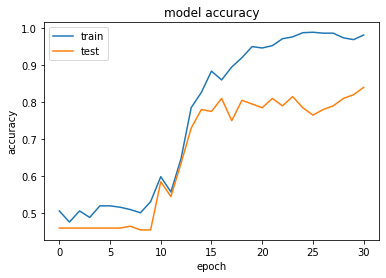

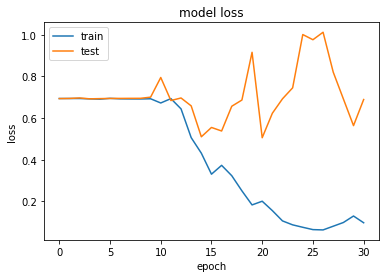

In [24]:
import numpy as np
from matplotlib import pyplot as plt 

def show_training_history(file_path):
    histories=np.loadtxt(file_path, delimiter=",")
    plt.plot(histories[:, 1])
    plt.plot(histories[:, 3])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(histories[:, 0])
    plt.plot(histories[:, 2])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
show_training_history("./model/sentiment-history.txt")